In [3]:
from google.colab import drive
drive.mount('/content/drive')
# uses modified version of scanpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install leidenalg

import os, sys
%cd "/content/drive/MyDrive/Colab Notebooks/scanpy"
sys.path.append(os.getcwd())
import os
import time
SCRIPT_DIR = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/')
!pip install -e "/content/drive/MyDrive/Colab Notebooks/scanpy"
import scanpy as sc
import anndata as ann
import pandas as pd
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from matplotlib import figure
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

# INPUT_DATA = os.path.join(SCRIPT_DIR, "DATA","sc2")
DF_PROCESSEDv4_DATAPATH = os.path.join(SCRIPT_DIR, "DATA","DF","df_processedv4.h5ad")
FIGURE_DIR = os.path.join(SCRIPT_DIR, "Plots", "Initial_Clustering")
!pip freeze "/content/drive/MyDrive/Colab Notebooks/DATA/requirements.txt"

Mounted at /content/drive
     |████████████████████████████████| 1.4MB 4.3MB/s 
     |████████████████████████████████| 3.2MB 37.8MB/s 
/content/drive/MyDrive/Colab Notebooks/scanpy
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/scanpy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/a4/68/da997bc56bb69dcdcee4054f0bc42266909307b905389fbc54c9158f42da/legacy_api_wrap-1.2-py3-none-any.whl
Processing /root/.cache/pip/wheels/43/a4/e5/d4e0a170ccc134e509ea55acad7845f0fdfa62b964e430f0e3/sinfo-0.3.4-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b8/ac/92f7a3687270dabd13c4bf8ec9ec4e9577df75311743982d63a644cff780/anndata-0.7.6-py3-none-any.whl
Processing /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4/umap_learn-0.5.1-cp37-none-any.whl
  Using cached h

In [30]:
# Trains binary classifier on provided cluster
def train_classifier(t2, scm, clust_idx, use_xgboost=True, method='exact', n_estimators=1000, max_depth=7):
  f2 = scm.obs['Timepoint'] == t2
  X2 = scm[f2].X
  y2 = (scm[f2]).obs[clust_idx]
  if use_xgboost:
    param_dist = {'method':'exact', 'n_estimators':n_estimators, 
                  'max_depth': max_depth, 'binary':'logistic'}
  else: #TODO: random forest classifier
    print("Random forest not implemented yet")
    return
  clf = XGBClassifier(**param_dist)
  start = time.time()
  X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.9, test_size=0.1, random_state=2)
  if len(y2_train.unique()) != len(y2_test.unique()):
    raise ValueError("Train and test labels do not overlap")
  clf.fit(X2_train, y2_train)
  plot_confusion_matrix(clf,X2_test,y2_test)
  end = time.time()
  print("Model split and trained using {} in {} seconds".format(method, end-start))
  return X2_train, X2_test, y2_train, y2_test, clf

def timepoint_probabilities(scm, tp, clust, plots, n_neighbors,min_dist, resolution):
  scm_n = scm[scm.obs['Timepoint'] == tp]
  start = time.time()
  sc.pp.neighbors(scm_n, n_neighbors,random_state=1)
  sc.tl.umap(scm_n, min_dist, n_components=2, random_state=1, alpha=1)
  plots.append(scm_n)
  stage = scm_n.obs['Stage'][0]
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color=clust, 
                save='_XGBOOST_CLUSTPROB_{}_TIMEPOINT_{}.png'.format(clust,tp))
  sc.pl.scatter(scm_n, 
                title='Timepoint: {} ({}), cells: {}, NN= {}'.format(tp, stage ,scm_n.n_obs, n_neighbors),
                basis='umap', color='leiden', save='_UMAP_OUTPUTS_Timepoint_{}.png'.format(tp))
  end = time.time()
  print("Time to visualize: "+ str(end-start) + " seconds")

In [34]:
# Graph Boost method
def nn_cluster_assignment(scm, tp, clust_idx, max_iter = 3, n_neighbors=15, neighbors_cutoff = 0.4, iteration_cutoff=0.005):
  scm_t = scm[scm.obs['Timepoint'] == tp]
  sc.pp.neighbors(scm_t, n_neighbors=n_neighbors+1)
  srm = scm_t.obsp['distances']
  print("Number of edges connected to cell 0: {}", len(np.argwhere(srm[0,:])))
  continue_assigning = True
  start = time.time()
  iter = 0
  while continue_assigning and iter <max_iter:
    n_unassigned_1 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_1))
    for cell_idx in range(srm.shape[0]):
      # skip checking on a cell_idx's neighbors if it is already assigned a cluster
      if scm_t.obs.at[scm_t.obs.index[cell_idx], clust_idx] == 1:
        continue
      nearest_obs = np.argwhere(srm[cell_idx,:])[:,1]
      vfunc = np.vectorize(lambda x: 1 if scm_t.obs.at[scm_t.obs.index[x], clust_idx] == 1 else 0)
      count_neighbors = np.sum(vfunc(nearest_obs))
      if count_neighbors/n_neighbors >= neighbors_cutoff:
        scm_t.obs.loc[scm_t.obs.index[cell_idx], clust_idx] = 1
    n_unassigned_2 = scm_t[scm_t.obs[clust_idx] == 0].n_obs
    # stop when new cells are being assigned to clusters at a very small proportion
    if n_unassigned_2 > (1-iteration_cutoff)*n_unassigned_1:
      continue_assigning = False
    iter += 1
  print("Number of cells not assigned to cluster {}: {}".format(clust_idx, n_unassigned_2))
  end = time.time()
  print("Time elapsed to conduct graph boost on {} at timepoint: {}: {}".format(clust_idx, tp, end-start))
  return scm_t

In [35]:
plt.rcParams["figure.figsize"] = (9,9) 

scm_ml = ann.read(DF_PROCESSEDv4_DATAPATH)
scm_ml.obs['leiden'] = scm_ml.obs['leiden'].astype(int)

#  add columns for probability and cluster assignments (all zeroes for now)
t_final = scm_ml.obs['Timepoint'].max()
num_classes = len(scm_ml[scm_ml.obs['Timepoint'] == t_final].obs['leiden'].unique())
# Column 'p(ci)' represents probability that an observation belongs to cluster i at t_final
prob_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                       index=scm_ml.obs.index, 
                       columns=['p(c'+str(i)+')' for i in range(num_classes)])
# Column ci represents formal cell assignment, based off a later-specified p threshold of p(ci)
clust_df = pd.DataFrame(data=np.zeros((scm_ml.n_obs, num_classes)),
                                    index=scm_ml.obs.index, 
                                    columns=['c' + str(i) for i in range(num_classes)])
scm_ml.obs = pd.concat([scm_ml.obs,prob_df,clust_df],axis=1)

# Assign initial ci with 1's to signify a cell belongs to the last timepoint leiden clusters; rest will remain zero 
for clust_idx in clust_df:
  clust_num = int(clust_idx[1])
  f = (scm_ml.obs['leiden'] == clust_num) & (scm_ml.obs['Timepoint'] == t_final)
  scm_ml.obs.loc[f, clust_idx] = 1


Model split and trained using exact in 147.02492547035217 seconds


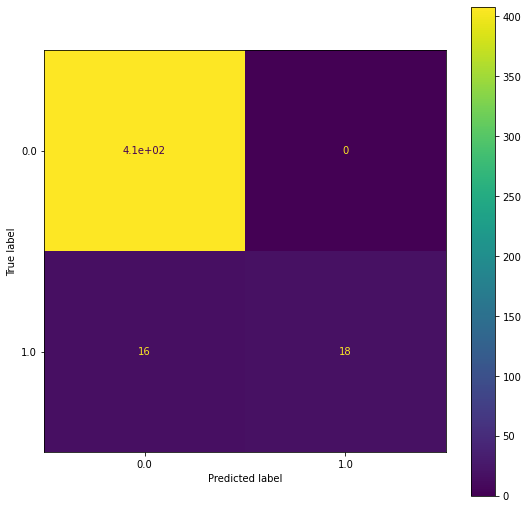

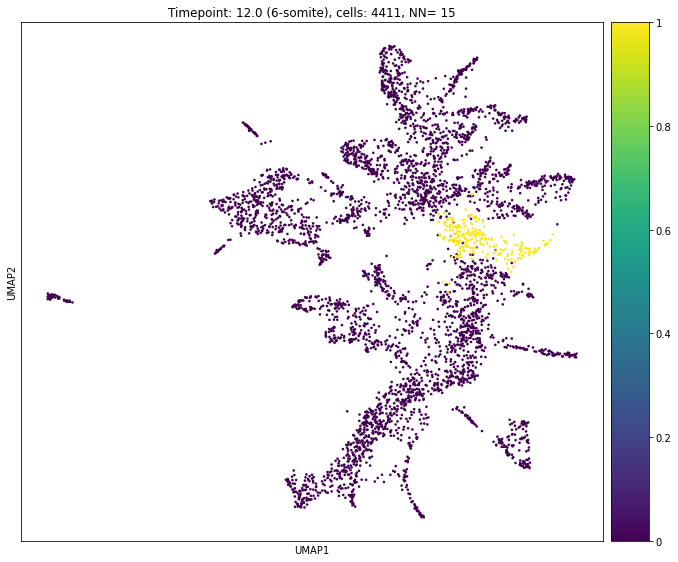

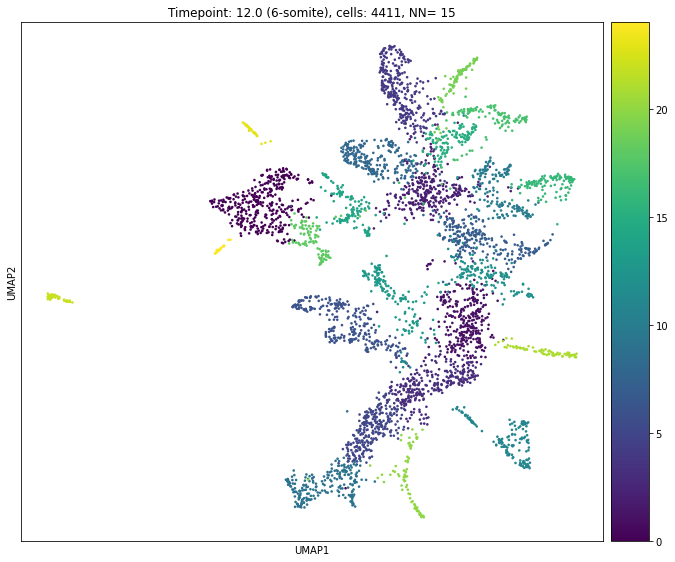

Time to visualize: 17.80457091331482 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 1535
Number of cells not assigned to cluster c7: 1505
Number of cells not assigned to cluster c7: 1469
Number of cells not assigned to cluster c7: 1455
Time elapsed to conduct graph boost on c7 at timepoint: 11.0: 2.026953935623169


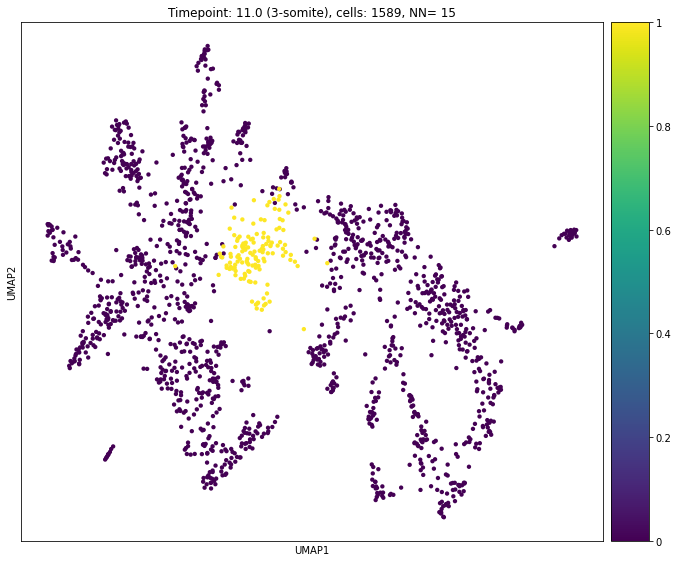

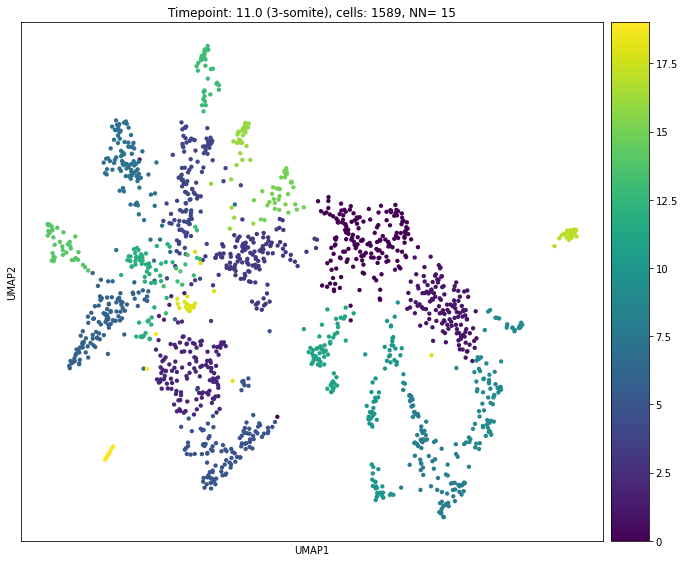

Time to visualize: 8.001308679580688 seconds
Model split and trained using exact in 42.201988697052 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 6926
Number of cells not assigned to cluster c7: 6871
Number of cells not assigned to cluster c7: 6794
Number of cells not assigned to cluster c7: 6723
Time elapsed to conduct graph boost on c7 at timepoint: 10.0: 9.280851125717163


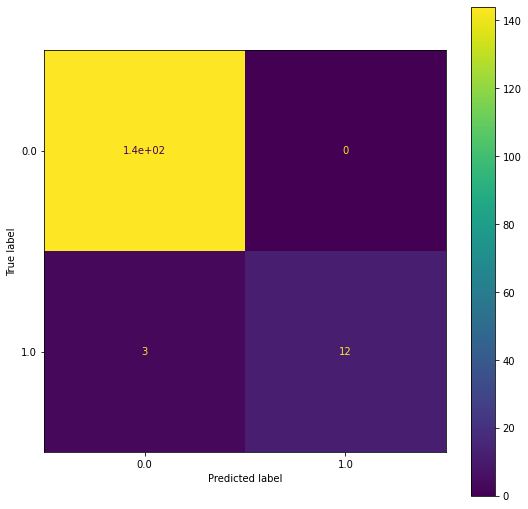

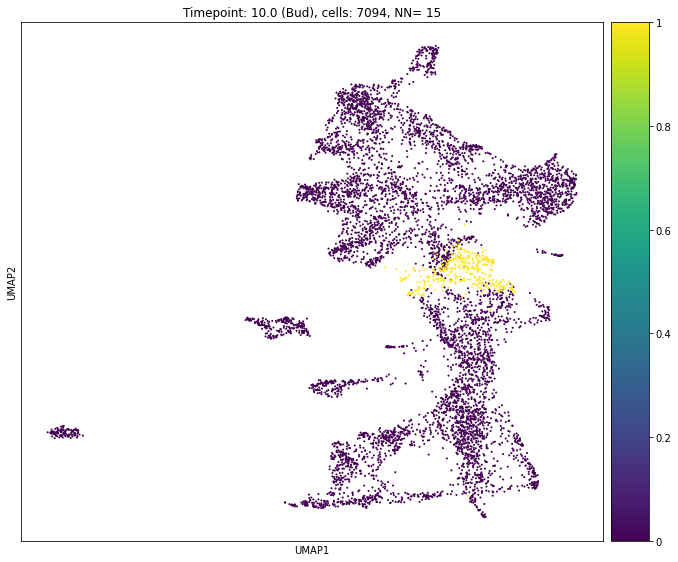

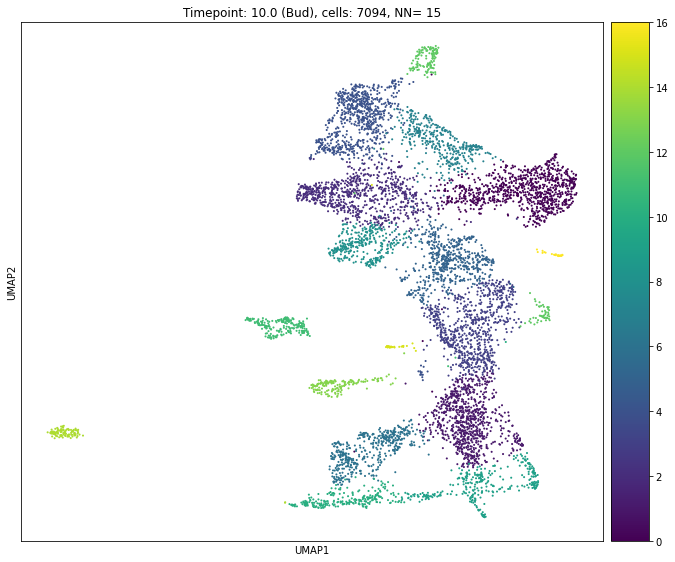

Time to visualize: 27.06939458847046 seconds
Model split and trained using exact in 257.7785439491272 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 5491
Number of cells not assigned to cluster c7: 5464
Time elapsed to conduct graph boost on c7 at timepoint: 9.0: 2.6261346340179443


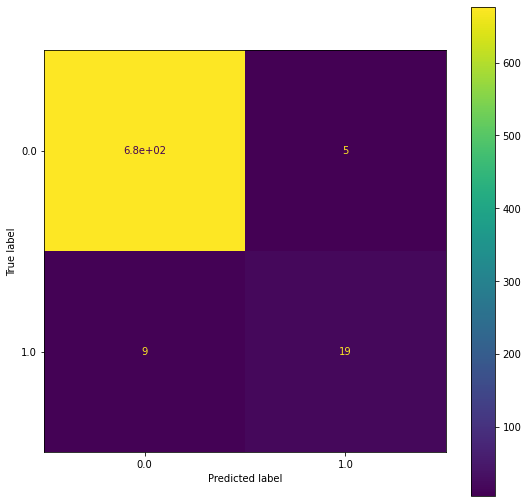

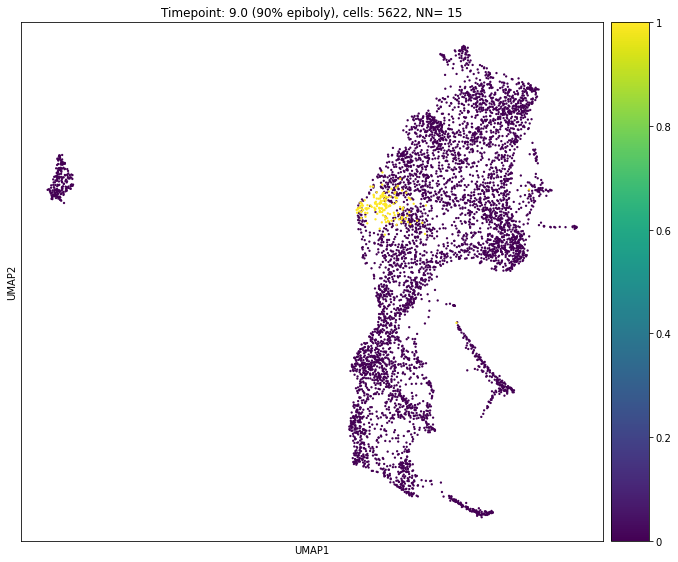

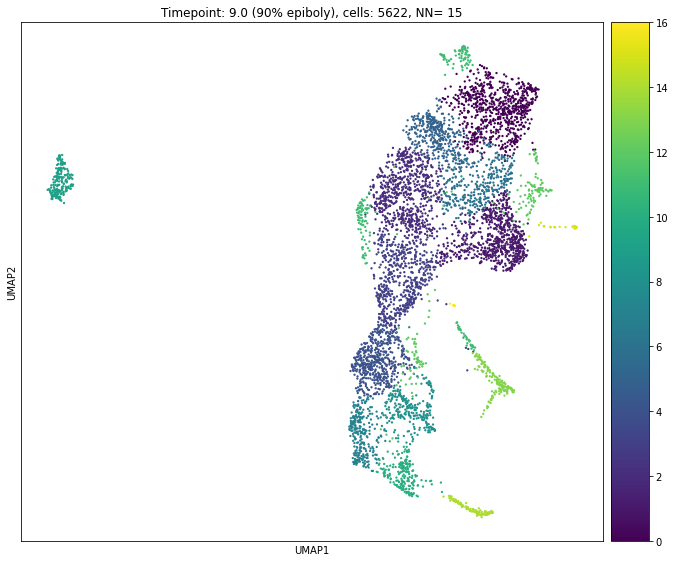

Time to visualize: 21.373502731323242 seconds
Model split and trained using exact in 146.3586721420288 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 6214
Number of cells not assigned to cluster c7: 6214
Time elapsed to conduct graph boost on c7 at timepoint: 8.0: 2.9060914516448975


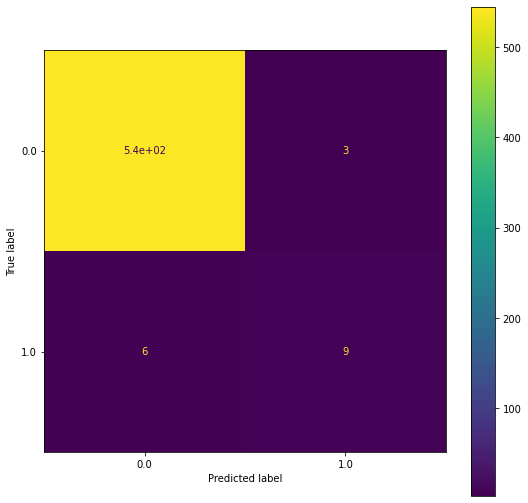

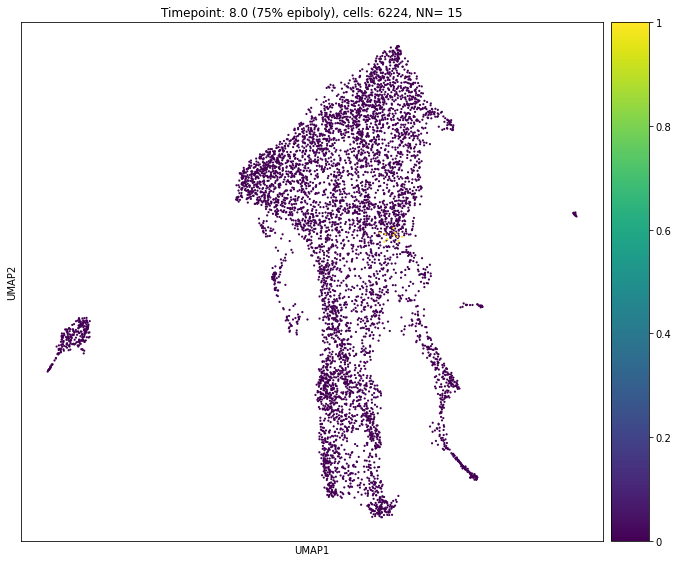

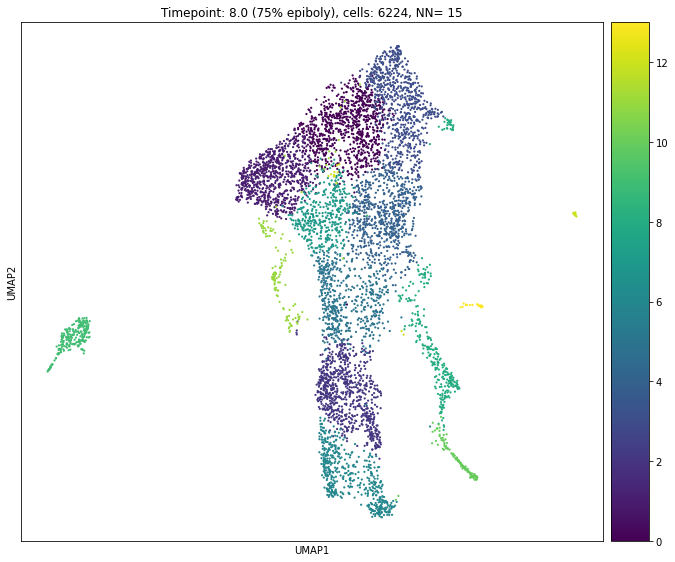

Time to visualize: 24.10724425315857 seconds
Model split and trained using exact in 88.97364521026611 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 4159
Number of cells not assigned to cluster c7: 4159
Time elapsed to conduct graph boost on c7 at timepoint: 7.0: 1.8197669982910156


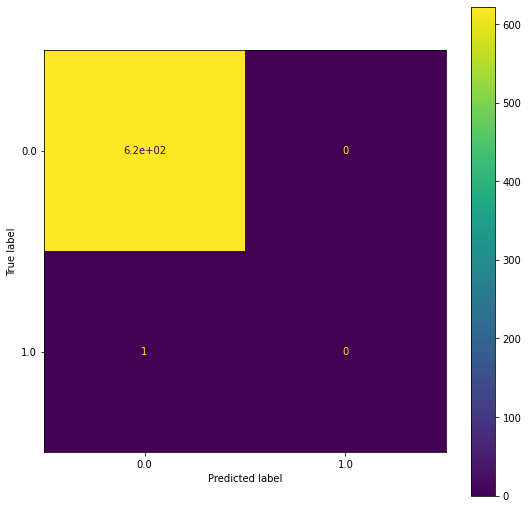

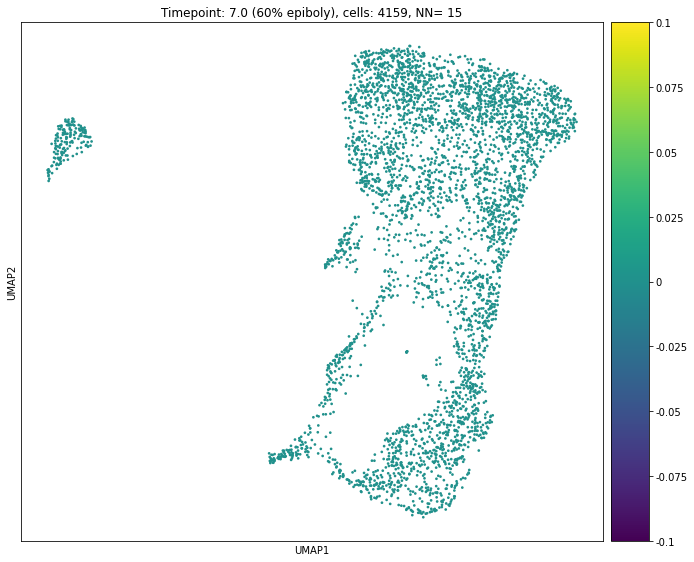

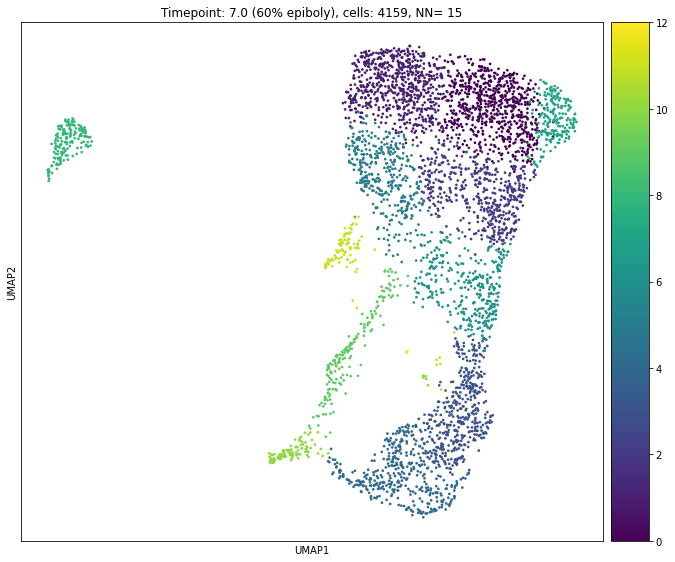

Time to visualize: 17.00399684906006 seconds
Model split and trained using exact in 52.54728984832764 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 1042
Number of cells not assigned to cluster c7: 1042
Time elapsed to conduct graph boost on c7 at timepoint: 6.0: 0.4967794418334961


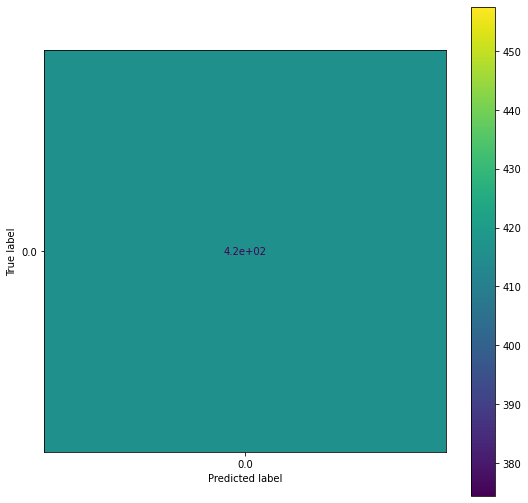

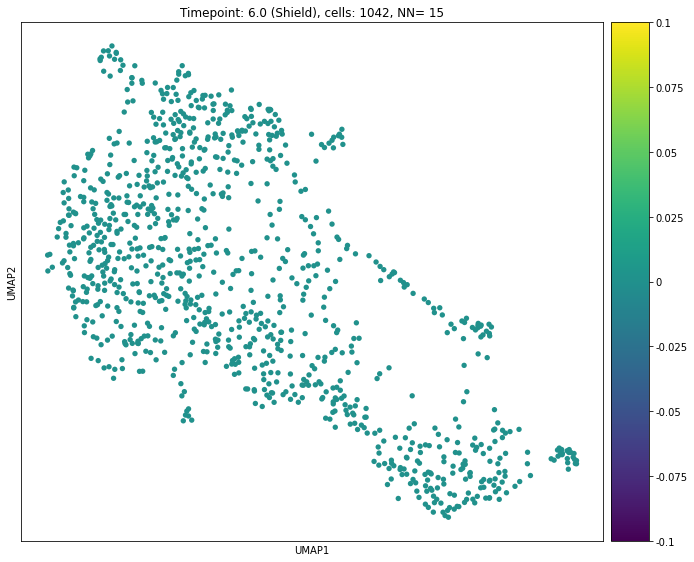

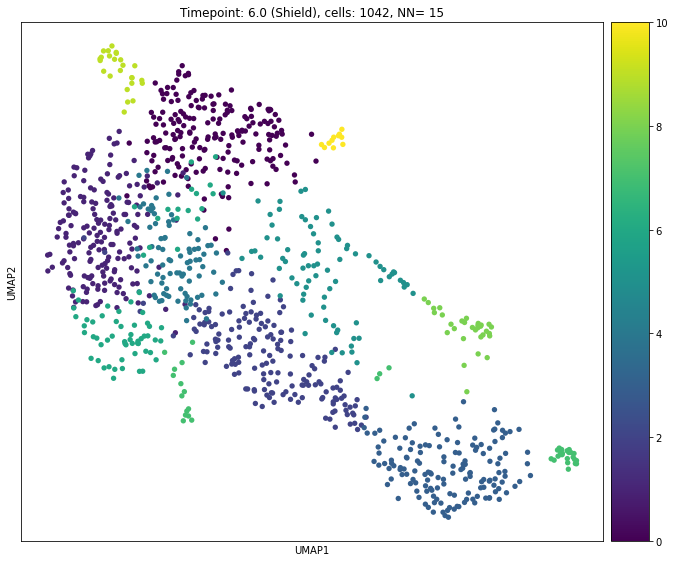

Time to visualize: 6.575000762939453 seconds
Model split and trained using exact in 13.703207015991211 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 5835
Number of cells not assigned to cluster c7: 5835
Time elapsed to conduct graph boost on c7 at timepoint: 5.3: 2.5794825553894043


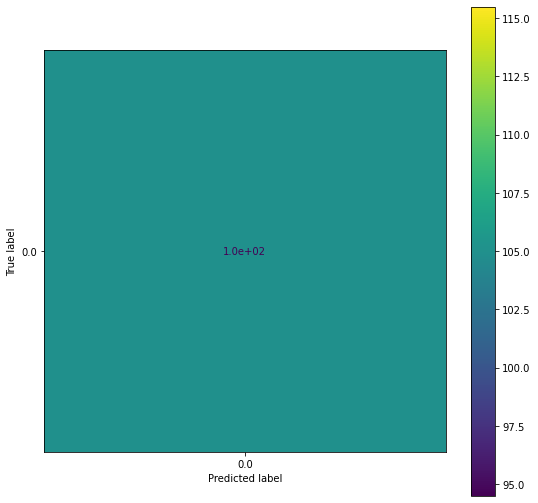

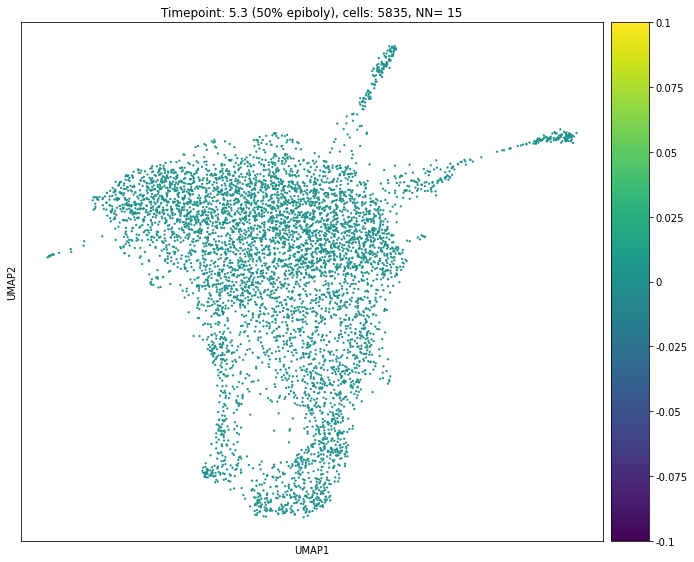

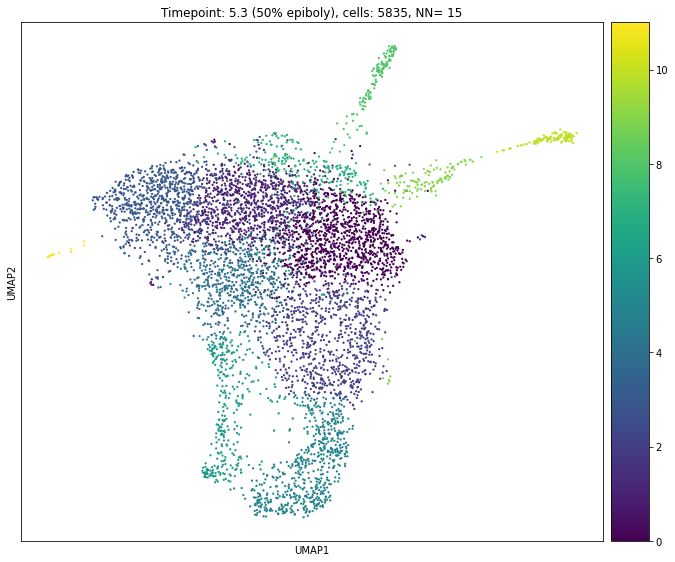

Time to visualize: 23.20928430557251 seconds
Model split and trained using exact in 73.21751093864441 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 1453
Number of cells not assigned to cluster c7: 1453
Time elapsed to conduct graph boost on c7 at timepoint: 4.7: 0.6524021625518799


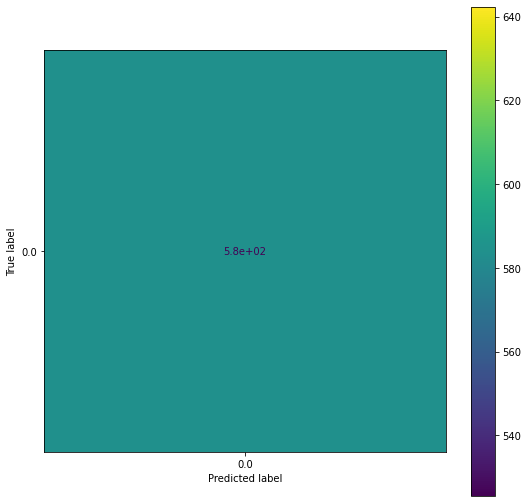

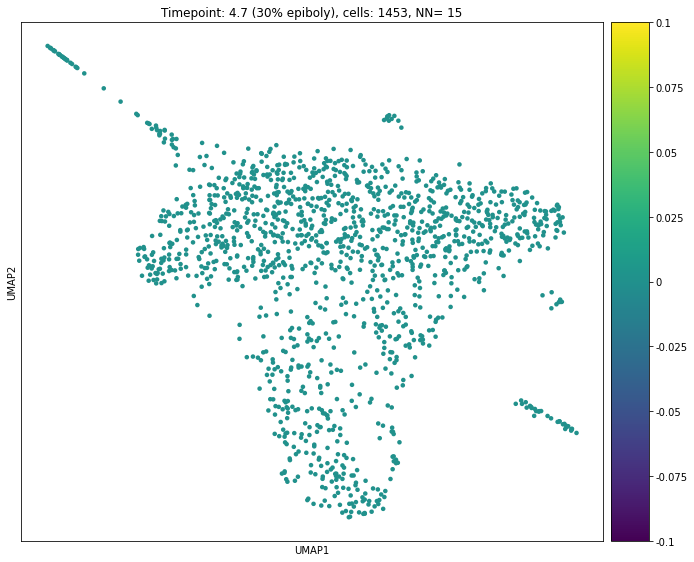

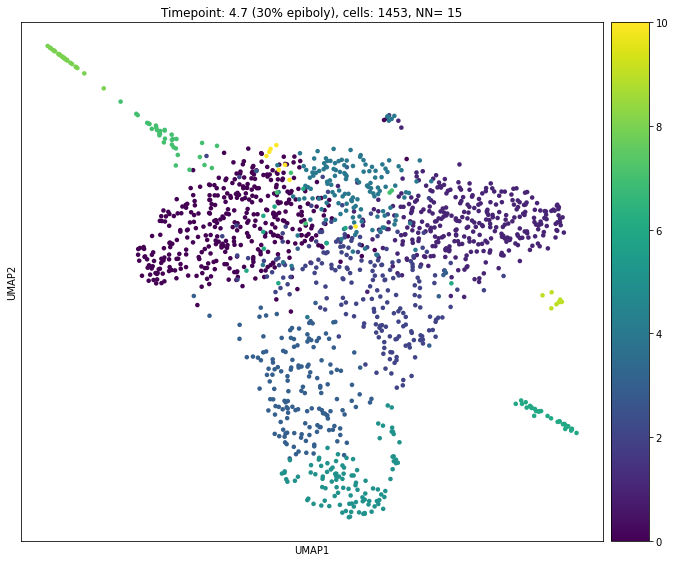

Time to visualize: 8.0575110912323 seconds
Model split and trained using exact in 18.875444173812866 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 1102
Number of cells not assigned to cluster c7: 1102
Time elapsed to conduct graph boost on c7 at timepoint: 4.3: 0.469937801361084


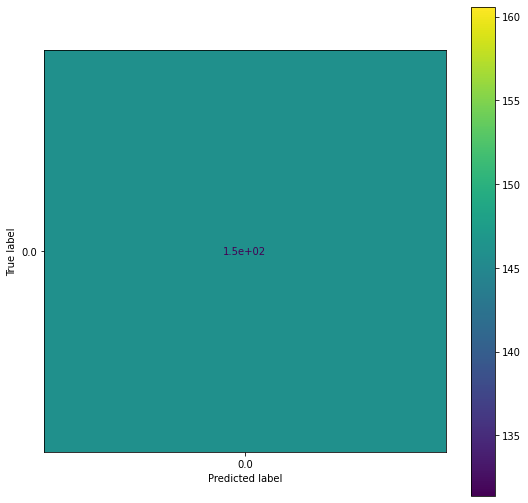

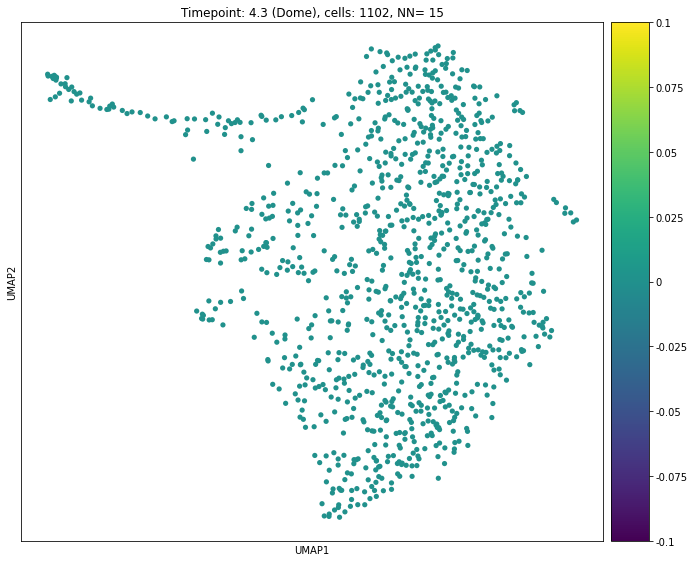

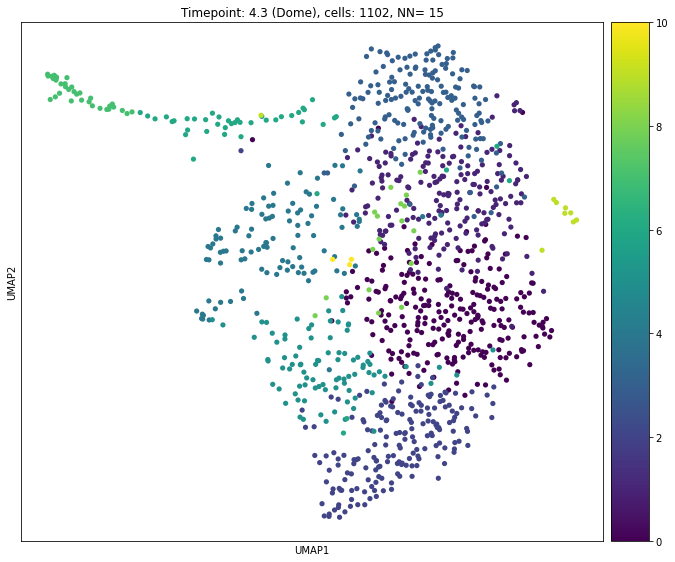

Time to visualize: 6.7933573722839355 seconds
Model split and trained using exact in 14.589263439178467 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 189
Number of cells not assigned to cluster c7: 189
Time elapsed to conduct graph boost on c7 at timepoint: 3.8: 0.12231564521789551


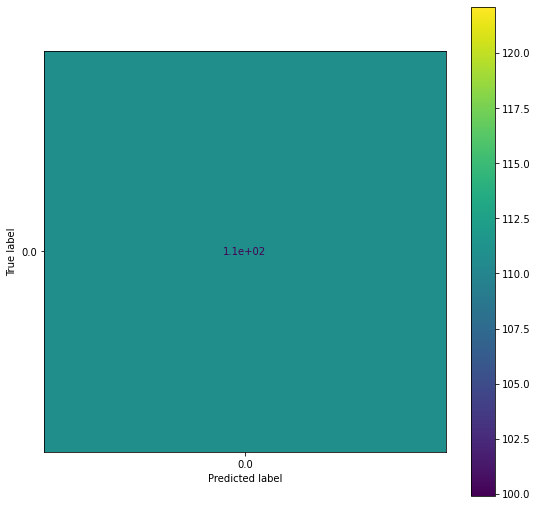

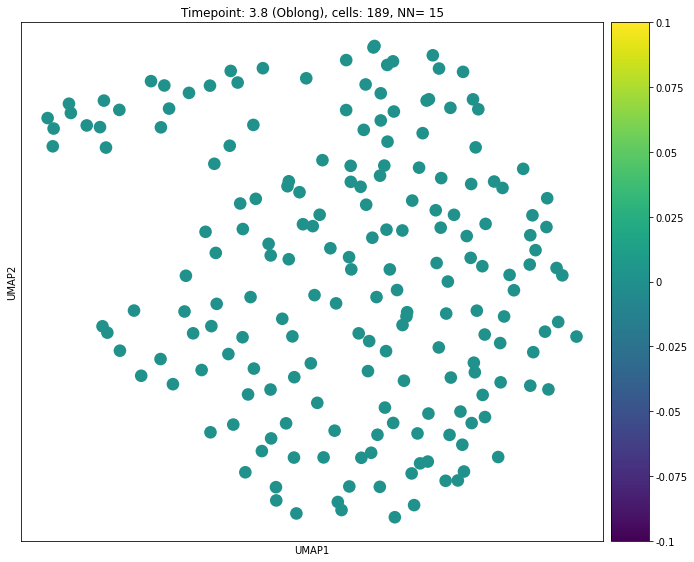

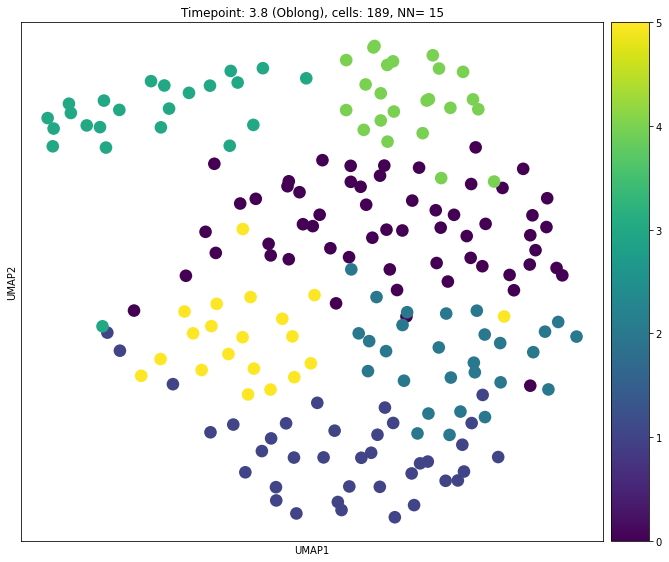

Time to visualize: 3.9180662631988525 seconds
Model split and trained using exact in 3.055389642715454 seconds
Number of edges connected to cell 0: {} 15
Number of cells not assigned to cluster c7: 310
Number of cells not assigned to cluster c7: 310
Time elapsed to conduct graph boost on c7 at timepoint: 3.3: 0.1909630298614502


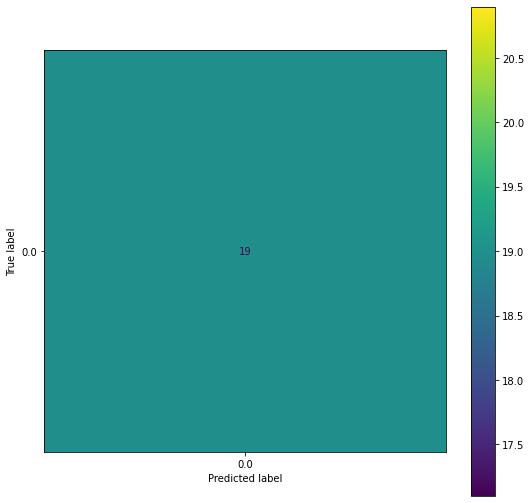

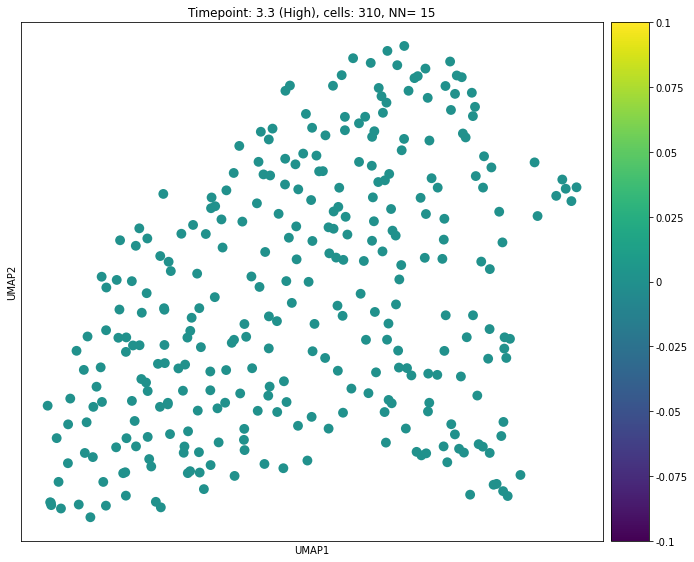

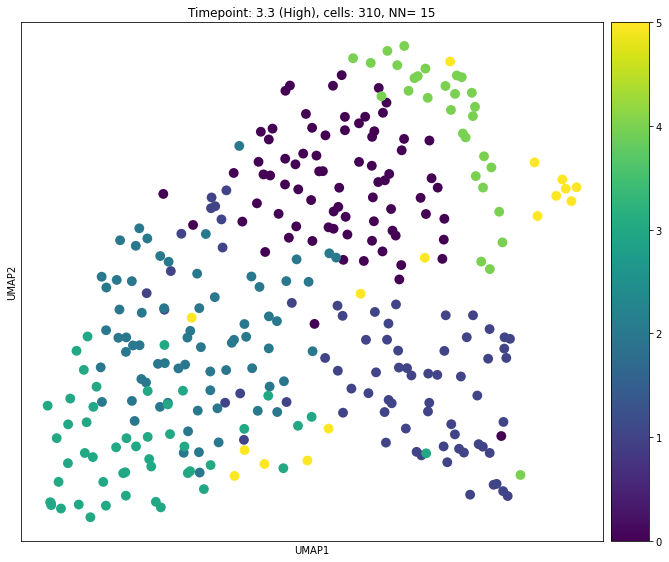

Time to visualize: 4.33261251449585 seconds


In [36]:
timepoints = list(set(scm_ml.obs['Timepoint']))
timepoints.sort()
n_timepoints = len(set(scm_ml.obs['Timepoint']))
CLUST_IDS = [7]
p = 0.55
plots = []
for i in range(n_timepoints-1):
  for clust_id in CLUST_IDS:      
    t2 = timepoints[-1*(i+1)]
    t1 = timepoints[-1*(i+2)]
    clust_idx = 'c' + str(clust_id)
    prob_idx = 'p(' + clust_idx + ')'
    X2_train, X2_test, y2_train, y2_test, clf = train_classifier(t2=t2, scm=scm_ml, clust_idx=clust_idx)
    labels = y2_test.unique()
    labels.sort()
    # TO DO: Create nicer ML validation result
    # y2_pred = clf.predict(X2_test)
    # prf = precision_recall_fscore_support(y_true=y2_test, y_pred=y2_pred, average=None, labels=labels)
    # P_IDX = 0
    # R_IDX = 1
    # train_threshold = 0.8
    # trust_arr=[]
    # def det_trust(arr):
    #   trust_arr.append(arr[P_IDX] >train_threshold and arr[R_IDX] > train_threshold)
    # np.apply_along_axis(det_trust, axis=0, arr=prf)
    # print(trust_arr)
    if t2 == t_final:
      # Just for completion, assign probabilities for initial timepoint as well
      X_t2= scm_ml[scm_ml.obs['Timepoint'] == t2].X
      y_t2 = clf.predict_proba(X_t2)
      scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t2,prob_idx] = y_t2[:,1]
      # plot
      timepoint_probabilities(scm_ml, t2, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
      # don't need to change cluster assignments since we already did that for t_final
    X_t1= scm_ml[scm_ml.obs['Timepoint'] == t1].X
    y_t1 = clf.predict_proba(X_t1)
    # update new probabilities at t1
    scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1,prob_idx] = y_t1[:,1]
    # update specified cluster's assignments for t1
    scm_ml.obs.loc[(scm_ml.obs['Timepoint'] == t1) & (scm_ml.obs[prob_idx] > p), clust_idx] = 1
    # conduct graph boosting for this specific cluster at t1
    scm_t = nn_cluster_assignment(scm_ml, t1, clust_idx)
    scm_ml.obs.loc[scm_ml.obs['Timepoint'] == t1, clust_idx] = scm_t.obs[clust_idx]
    timepoint_probabilities(scm_ml, t1, clust_idx, plots, n_neighbors=15, min_dist=0.3, resolution=1)
